In [2]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from os import listdir
from os.path import join
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from itertools import product
from multiprocessing import Pool

_default_date_format = "%Y-%m-%d"

In [3]:
# Read in data
covid_state = {}
state_dir = join("..", "data", "input", "states")
for filename in listdir(state_dir):
    if filename[-4:] == ".csv":
        covid_state[filename[:-4]] = pd.read_csv(join(state_dir, filename))
        
state_list = list(covid_state.keys())

In [11]:
def date_to_int(date_string: str, form: str=_default_date_format) -> int:
    """Return date date_string in format form as an integer"""
    return dt.datetime.strptime(date_string, form).toordinal()

def int_to_date(ordinal: int, form: str=_default_date_format) -> str:
    """Return the day number ordinal to as a string, formatted with form"""
    return dt.datetime.fromordinal(ordinal).strftime(form)

def add_lag(df, feature_dict, trim=True):
    series_list = []
    for feature in feature_dict.keys():
        for n in feature_dict[feature]:
            if n != 0:
                series = df[feature].shift(n).copy().rename(feature+str(n))
                series_list.append(series) 
    untrimmed = pd.concat([df[feature_dict.keys()]] + series_list, axis=1).copy()
    if trim:
        return untrimmed.iloc[max(np.max(feature_dict[feature]) \
                                  for feature in feature_dict \
                                 if len(feature_dict[feature]) > 0):]
    else:
        return untrimmed
    
def simple_linear(delay, state, dates=["2021-01-01", "2021-09-01"],
                  plot=False, params=(10,4,10,25), xgboost=False):
    """ Return the ratio of average linear regression MSE to
    average baseline MSE for predicted number of hospital beds
    occupied by COVID patients. Smaller output is better.
    
        delay: the number of days in the future we want to predict
        state: which state to use
        dates[0], dates[1]: start and end dates
        plot: should we display plot of the predicted and actual counts?
        params: hyperparameters, which are
            train_length: the number of days' data to use to train
            a: the number of previous bed usages to use
            b: the number of previous case numbers to use
            alpha: regularization parameter in ridge regression
    
    Baseline predicts number of beds used today equals the number of beds
    used in the most recent available data (which is delay days old).
    It appears optimal hyperparameters for this model depend on the state.
    """
    train_length, num_bed_days, num_case_days, alpha = params
    state_data = covid_state[state]
    
    features = [f"beds{n}" for n in range(delay, delay+num_bed_days)] + \
                [f"cases{n}" for n in range(delay, delay+num_case_days)] + \
                [f"Administered{delay}"]
    assert train_length >= len(features)
    
    # Don't use data from September 2021 or later
    state_train = state_data.loc[state_data.day_number < \
                                 date_to_int(dates[1])].copy()
    
    state_train.rename({"inpatient_beds_used_covid": "beds",
                   "new_case": "cases"}, axis=1, inplace=True)



    # Sometimes there are outlying data points that
    # substantially impact estimation. This will remove them
    is_outlier = lambda x: False # Should be customized for each state
    for index in state_train.index:
        if is_outlier(state_train.beds[index]):
            state_train.loc[index, "beds"] = state_train.beds[index-1]

    pruned_lag = add_lag(state_train,
                         {"beds": range(delay, delay+num_bed_days),
                             "cases": range(delay, delay+num_case_days),
                             "Administered": [delay],
                             "day_number": [],
                             "date": []})
    # Starting day for model evaluation
    day = date_to_int(dates[0]) + delay + train_length

    X = []
    Y_actual = []
    Y_baseline = []
    Y_regression = []
    endpoint = pruned_lag.day_number.max()
    predicted = None
    while day < endpoint:
        train = pruned_lag.loc[(pruned_lag.day_number<=day-delay)
                        & (pruned_lag.day_number>day-delay-train_length)].copy()
        test = pruned_lag.loc[pruned_lag.day_number == day].copy()


        

        if xgboost:
            pipe = Pipeline([('scaler', StandardScaler()),
                        ('xgb', xgb.XGBRegressor(objective='reg:squarederror',
                                                 colsample_bytree = 0.3,
                                                 learning_rate = 0.1,
                                                 max_depth = 25,
                                                 alpha = alpha,
                                                 n_estimators = 200))])
        else:
            pipe = Pipeline([('scaler', StandardScaler()),
                            ('ridge', Ridge(copy_X=True, alpha=alpha, max_iter=10**8))])
        
        pipe.fit(train[features], train.beds)
        actual = test.beds.iloc[0]
#         X.append(test.index[0])
        X.append(test.day_number.iloc[0])
        Y_actual.append(actual)
        Y_baseline.append(test[f"beds{delay}"].iloc[0])
        old_predicted = predicted
        predicted = pipe.predict(test[features])[0]
        if old_predicted is not None and old_predicted > 0 and False:
            if predicted / old_predicted > 1.25:
                predicted = old_predicted * 1.25
            if predicted / old_predicted < .9:
                predicted = old_predicted * .9
        Y_regression.append(predicted)
        if day == 737815 and False:
            print(train)
            print(test)
        day += 1

    if plot:
        plt.figure(figsize=(7,7))
        plt.xlabel("Day")
        plt.ylabel(f"Hospital beds filled in {state}")
        plt.title(f"Predictions made {delay} days in advance")
        plt.plot(Y_actual, label="Actual")
        plt.plot(Y_baseline, label="Predicted (baseline)")
        plt.plot(Y_regression, label="Predicted (regression)")
        plt.legend()
    mse_regression = mean_squared_error(Y_actual, Y_regression)
    mse_baseline = mean_squared_error(Y_actual, Y_baseline)
    return mse_regression / mse_baseline

WV [10, 1, 2, 8, 'WV']


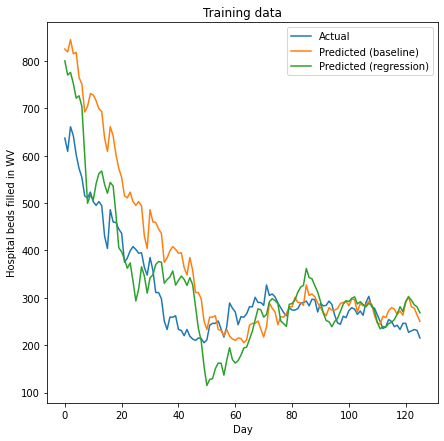

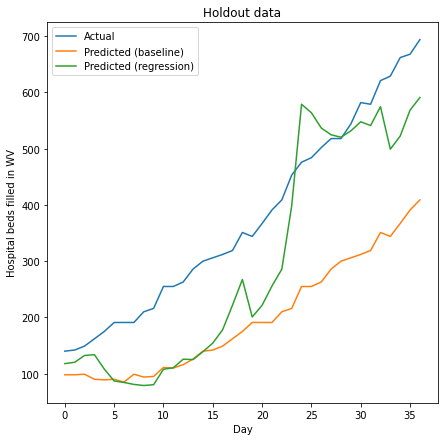

0.30081107101423193
VA [20, 1, 1, 8, 'VA']


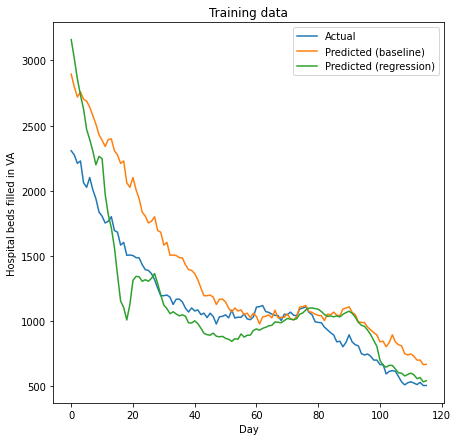

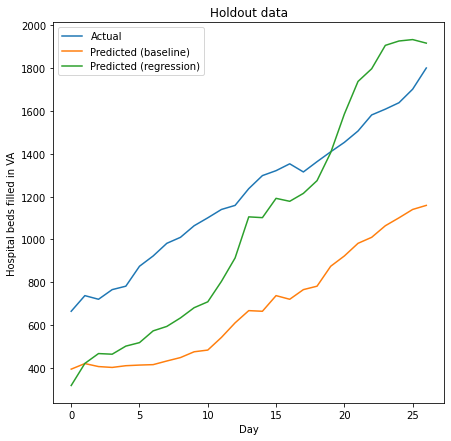

0.25603197523059235


KeyboardInterrupt: 

In [12]:
# Number of days in the future to predict
future = 14

# Generate a list of parameters to check
# (this is enormously inefficient)
param_list = []
for s in product(range(10,25,5),
       [1,2,3,4],
        [1,2,3,4,6,8],
        [1,2,4,8,16,32,40,50,70,90]):
    if s[0] >= s[1] + s[2] + 1:
        param_list.append(s)
len(param_list)

# Need a function of one argument for multiprocessing
def f(params):
    return simple_linear(future,
               params[-1],
               plot=False,
               params=params[:-1],
               dates=["2021-01-01", "2021-06-01"]), params

# Iterate through states, tuning hyperparameters using the first
# five months of 2021. Then see how good is the prediction
# using those hyperparameters to predict July and August.
# Show a graph of the prediction on training data and holdout data.
for state in state_list:
    minimum = None
    p0 = None
    with Pool(10) as pool:
        for M in pool.imap_unordered(f,
                                     [list(s) + [state] for s in param_list],
                                     chunksize=5):
            if minimum is None or M[0] < minimum:
                minimum = M[0]
                p0 = M[1]
    print(state, p0)
    A = simple_linear(future,
               state,
               plot=True,
               params=p0[:-1],
               dates=["2021-01-01", "2021-06-01"])
    plt.title("Training data")
    plt.show()
    A = simple_linear(future,
               state,
               plot=True,
               params=p0[:-1],
               dates=["2021-07-01", "2021-09-01"])
    plt.title("Holdout data")
    plt.show()
    print(A)